In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import salem

%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
file = '/media/ck/LStorage/wrfout_07_merge.nc'

In [4]:
da = xr.open_dataset(file)

In [5]:
def open_wrf_dataset(file, pole_longitude=0, pole_latitude=0,
                       central_rotated_longitude=0., **kwargs):
   

    # open with xarray
    ds = xr.open_dataset(file, **kwargs)

    srs = ('+ellps=WGS84 +proj=ob_tran +o_proj=latlon '
           '+to_meter=0.0174532925199433 '
           '+o_lon_p={o_lon_p} +o_lat_p={o_lat_p} +lon_0={lon_0} +no_defs')
    params = {
        'o_lon_p': central_rotated_longitude,
        'o_lat_p': pole_latitude,
        'lon_0': 180 + pole_longitude,
    }
    srs = srs.format(**params)

    # add pyproj string everywhere
    ds.attrs['pyproj_srs'] = srs
    for v in ds.data_vars:
        ds[v].attrs['pyproj_srs'] = srs

    return ds

In [6]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [17]:
ds = open_wrf_dataset(file)

In [18]:
da = ds['U'].sel(time = ds.time.dt.hour.isin([12,15,18])).groupby('time.hour').mean('time')

In [28]:
grid = da.salem.grid
grid

<salem.Grid>
  proj: +ellps=WGS84 +lon_0=180 +no_defs+o_lat_p=0 +o_lon_p=0 +o_proj=latlon +proj=ob_tran
  pixel_ref: center
  origin: lower-left
  (nx, ny): (798, 425)
  (dx, dy): (5000.0, 0.04709625244140625)
  (x0, y0): (-1992500.0, 10.218177795410156)

In [29]:
da

<xarray.DataArray 'U' (hour: 3, bottom_top: 30, latitude: 425, longitude: 798)>
array([[[[ 3.06458735e+00,  3.08969069e+00,  3.11427760e+00, ...,
           1.94091272e+00,  1.91565037e+00,  1.91132987e+00],
         [ 5.79223680e+00,  6.41195583e+00,  3.70262861e+00, ...,
           1.83931673e+00,  1.75319040e+00,  1.79753721e+00],
         [ 6.12518930e+00,  7.03401566e+00,  3.96783805e+00, ...,
           1.72701204e+00,  1.64264393e+00,  1.74136257e+00],
         ...,
         [-1.52575934e+00, -1.28498876e+00, -5.06460238e+00, ...,
          -8.91673923e-01, -8.85820985e-01, -1.02448261e+00],
         [-2.40090775e+00, -2.24622631e+00, -5.18056250e+00, ...,
          -1.00416481e+00, -1.00300968e+00, -1.08348370e+00],
         [-5.37531948e+00, -5.38026428e+00, -5.38980389e+00, ...,
          -1.09722507e+00, -1.11664701e+00, -1.13587058e+00]],

        [[ 3.06458735e+00,  3.08969069e+00,  3.11427760e+00, ...,
           2.07169485e+00,  2.05401134e+00,  2.04985428e+00],
         [ 4.28964376e+00,  4.65946531e+00,  3.47213721e+00, ...,
           2.09200430e+00,  2.03837061e+00,  2.02642608e+00],
         [ 4.35141993e+00,  4.83694983e+00,  3.56723428e+00, ...,
           2.00005770e+00,  1.93514931e+00,  1.96998382e+00],
...
           2.23697519e+00,  2.20617747e+00,  1.97545254e+00],
         [ 9.41373158e+00,  9.23776054e+00,  9.33166599e+00, ...,
           2.13890791e+00,  2.14499664e+00,  2.01348615e+00],
         [ 9.74534893e+00,  9.74009323e+00,  9.73511982e+00, ...,
           2.05077243e+00,  2.03521204e+00,  2.01903319e+00]],

        [[-1.12745028e+01, -1.12753000e+01, -1.12757511e+01, ...,
          -2.11562023e+01, -2.11537971e+01, -2.11514950e+01],
         [-1.13193102e+01, -1.13264332e+01, -1.13402328e+01, ...,
          -2.11755791e+01, -2.12413464e+01, -2.12320747e+01],
         [-1.13821888e+01, -1.14078465e+01, -1.14210215e+01, ...,
          -2.11888142e+01, -2.12794437e+01, -2.12704983e+01],
         ...,
         [ 6.24370527e+00,  5.93765783e+00,  6.01404476e+00, ...,
           1.94798663e-01,  1.72485426e-01, -1.59999132e-02],
         [ 6.46439219e+00,  6.28455925e+00,  6.35945702e+00, ...,
           1.21521711e-01,  1.30157262e-01,  2.43283547e-02],
         [ 6.78263330e+00,  6.77962446e+00,  6.77669239e+00, ...,
           6.30489439e-02,  5.28576113e-02,  4.22298461e-02]]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -20.07 -20.02 -19.98 ... 17.98 18.02 18.07
  * latitude   (latitude) float32 10.22 10.27 10.31 10.36 ... 29.13 29.17 29.21
    lat        (latitude, longitude) float32 10.22 10.22 10.22 ... 29.21 29.21
    lon        (latitude, longitude) float32 -20.07 -20.02 ... 18.02 18.07
    west_east  (longitude) float64 ...
  * hour       (hour) int64 12 15 18
Dimensions without coordinates: bottom_top
Attributes:
    units:        m s-1
    FieldType:    104
    MemoryOrder:  XYZ
    description:  x-wind component
    stagger:      X
    pyproj_srs:   +ellps=WGS84 +proj=ob_tran +o_proj=latlon +to_meter=0.01745...

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._axes.Axes'>

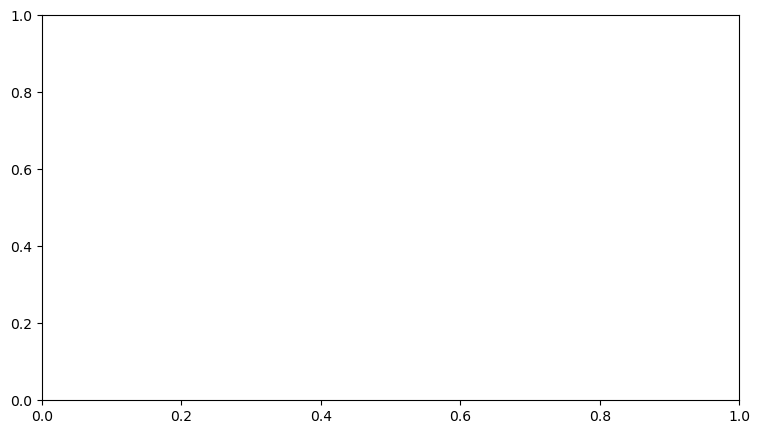

In [30]:
f = plt.figure(figsize=(9,5))
ax = f.add_subplot(111)
draw_map(ax, da.sel(hour=15).isel(bottom_top=3), da.lat, da.lon, title='WRF file', cmap='RdBu_r')